<a href="https://colab.research.google.com/github/honeyd3wy/quill-helper/blob/main/Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/cp1/kkp_info_preprocessed.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,id,title,writer,readers,total_comments,genre,grade,days_of_week,total_episode,free,publish_info
0,58289261,남주들의 집착보다 내 탈영이 빠르겠다,아듀,297000,14000,로판,전체이용가,"월,화,수,토,일",97,기다무,독점
1,55275635,마법황가 무공천재,주문향,317000,7712,판타지,전체이용가,완결,298,기다무,일반
2,52716578,불패검선,적하,308000,6674,무협,전체이용가,완결,253,기다무,일반
3,58404017,7번의 결혼이 예정되어 있습니다,커피바닐라,323000,5112,로판,전체이용가,"월,화,수,목,토,일",94,기다무,독점
4,47050646,템빨,박새날,2818000,549000,판타지,전체이용가,"월,수,금,토",1581,기다무,일반


In [54]:
df.isna().sum()

id                0
title             0
writer            0
readers           0
total_comments    0
genre             0
grade             0
days_of_week      0
total_episode     0
free              0
publish_info      0
dtype: int64

In [55]:
df = df.drop_duplicates(['id'])

In [56]:
len(df)

4072

In [57]:
df_description = pd.read_csv('/content/drive/MyDrive/cp1/description.tsv', sep='\t')
df_description.drop(columns=['Unnamed: 0'], inplace=True)
df_description.head()

,id,description,title,genre
0,58289261,"""너는 오래 전 죽은 그 애를 참 닮았군.""의 '그 애' 역할로 빙의했다. 군부를...",남주들의 집착보다 내 탈영이 빠르겠다,로판
1,55275635,[카카오 독점 연재] 혈마(血魔) 천무정. 피도 눈물도 없는 무림 최강의 존재. ...,마법황가 무공천재,판타지
2,52716578,"시골 객점의 아들 송우문. 어릴 적부터 몸이 약했던 그는, 어느 날 노도사가 그려 ...",불패검선,무협
3,58404017,아가사 노빌리스는 몇 세기 만에 나온 어마어마한 자산의 상속녀였다. 결혼을 6번 ...,7번의 결혼이 예정되어 있습니다,로판
4,47050646,공사장에서 벽돌 나르고 삽질하는 불운한 인생의 신영우. 그런데 심지어 게임 속에서 ...,템빨,판타지


# Feature Engineering

In [58]:
# 편당 평균 댓글 수
df['avg_comments'] = df['total_comments'] / df['total_episode']

In [59]:
# 주당 연재 요일 수
df['days_of_week'] = df['days_of_week'].apply(lambda x: x.replace(',', ''))
df['days_count'] = df['days_of_week'].apply(lambda x: 7 if x=='매일' else(0 if x=='중' else len(x)))
  # '중'은 비정기 연재로, 0으로 임의 표기

In [60]:
df['days_of_week'].unique()
df['days_count'].unique()

array([5, 2, 6, 4, 0, 7, 3, 1])

In [61]:
# 제목 길이
df['title'] = df['title'].apply(lambda x: x.replace('[연재]','') if '[연재]' in x else x)
df['title_len'] = df['title'].apply(lambda x: len(x))

In [62]:
# 독자수로 5개 등급 나누기
df['novel_grade'] = pd.qcut(df['readers'], 5, labels=['E', 'D', 'C', 'B', 'A']).astype(str)

In [63]:
df

,id,title,writer,readers,total_comments,genre,grade,days_of_week,total_episode,free,publish_info,avg_comments,days_count,title_len,novel_grade
0,58289261,남주들의 집착보다 내 탈영이 빠르겠다,아듀,297000,14000,로판,전체이용가,월화수토일,97,기다무,독점,144.329897,5,20,B
1,55275635,마법황가 무공천재,주문향,317000,7712,판타지,전체이용가,완결,298,기다무,일반,25.879195,2,9,B
2,52716578,불패검선,적하,308000,6674,무협,전체이용가,완결,253,기다무,일반,26.379447,2,4,B
3,58404017,7번의 결혼이 예정되어 있습니다,커피바닐라,323000,5112,로판,전체이용가,월화수목토일,94,기다무,독점,54.382979,6,17,B
4,47050646,템빨,박새날,2818000,549000,판타지,전체이용가,월수금토,1581,기다무,일반,347.248577,4,2,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4073,46719933,기생열전,태상미,190000,1539,로맨스,전체이용가,완결,58,기다무,일반,26.534483,2,5,C
4074,53729117,다시 쓰는 폭군의 비망록,볼테르,143000,621,판타지,전체이용가,완결,245,기다무,일반,2.534694,2,13,D
4075,52841411,탑 기타리스트,위천풍,116000,271,현판,전체이용가,완결,185,기다무,일반,1.464865,2,7,E
4076,52009346,내가 만든 세상에서 살아남기,팔복,168000,1087,판타지,전체이용가,완결,235,기다무,일반,4.625532,2,16,D


In [64]:
df[(df['novel_grade']=='A') | (df['novel_grade']=='B')]

,id,title,writer,readers,total_comments,genre,grade,days_of_week,total_episode,free,publish_info,avg_comments,days_count,title_len,novel_grade
0,58289261,남주들의 집착보다 내 탈영이 빠르겠다,아듀,297000,14000,로판,전체이용가,월화수토일,97,기다무,독점,144.329897,5,20,B
1,55275635,마법황가 무공천재,주문향,317000,7712,판타지,전체이용가,완결,298,기다무,일반,25.879195,2,9,B
2,52716578,불패검선,적하,308000,6674,무협,전체이용가,완결,253,기다무,일반,26.379447,2,4,B
3,58404017,7번의 결혼이 예정되어 있습니다,커피바닐라,323000,5112,로판,전체이용가,월화수목토일,94,기다무,독점,54.382979,6,17,B
4,47050646,템빨,박새날,2818000,549000,판타지,전체이용가,월수금토,1581,기다무,일반,347.248577,4,2,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3963,49784312,역천의 왕,문유,232000,3116,판타지,전체이용가,완결,240,기다무,일반,12.983333,2,6,B
3965,49446726,"하녀, 여왕이 되다[단독선공개]",우수빈,319000,11000,로판,전체이용가,완결,162,기다무,일반,67.901235,2,17,B
3995,48336717,달이 뜨지 않는 밤,담덕,244000,4218,현판,전체이용가,완결,104,기다무,일반,40.557692,2,10,B
4006,51425696,던전을 만든 신이 보인다,웨우,238000,3696,판타지,전체이용가,완결,246,기다무,일반,15.024390,2,13,B


# EDA

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [65]:
# 판타지(판타지+로판+현판), 로맨스, 무협으로 분리
romance_fantasy = df[df['genre']=='로판']
fantasy = df[df['genre']=='판타지']
real_fantasy = df[df['genre']=='현판']

# 판타지 전체
fantasy_all = pd.concat([romance_fantasy, fantasy, real_fantasy])
# 무협
martial = df[df['genre']=='무협']
# 일반 로맨스
romance = df[df['genre']=='로맨스']

장르별 top 5 제목

In [66]:
def top5(genre):
    new_df = df.sort_values(by='readers', ascending=False)
    return new_df[new_df['genre' ]== genre][:10]['title'].reset_index(drop=True)

top_5_title = {'로맨스 판타지': top5('로판'),
               '판타지': top5('판타지'),
               '현실 판타지': top5('현판'),
               '무협' : top5('무협'),
               '일반 로맨스': top5('로맨스')}
top_5_title_df = pd.DataFrame(top_5_title)
top_5_title_df

,로맨스 판타지,판타지,현실 판타지,무협,일반 로맨스
0,황제의 외동딸,달빛조각사,닥터 최태수,묵향,김 비서가 왜 그럴까
1,왕의 딸로 태어났다고 합니다,나 혼자만 레벨업,마존현세강림기,구천구검,사내 맞선
2,아도니스,템빨,갓 오브 블랙필드,무당기협,화홍
3,검을 든 꽃,검술명가 막내아들,이번 생은 우주대스타,화산전생,애완견의 법칙
4,나는 이 집 아이,두 번 사는 랭커,데뷔 못 하면 죽는 병 걸림,학사재생,조선 세자빈 실종 사건
5,아기는 악당을 키운다,무한의 마법사,저승식당,전생검신,아기 후궁님은 조용히 살고 싶어
6,외과의사 엘리제,밥만 먹고 레벨업,신군 : 시간을 사는 남자,남궁세가 막내공자,낙화유수
7,버림 받은 황비,마탄의 사수,그레이트 써전,악인들의 대사형,비서실격
8,악당의 아빠를 꼬셔라,나는 될놈이다,1년차 만렙 매니저,로그인 무림,짐승같은 스캔들
9,이번 생은 가주가 되겠습니다,레벨업 못하는 플레이어,이것이 법이다,화산권마,거지왕자


작품 중 장르 비율

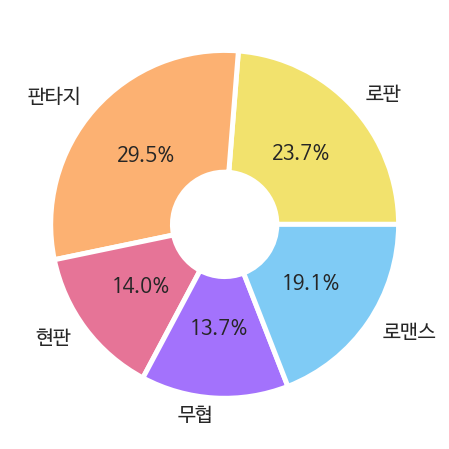

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(8,8))
ratio = [len(df[df['genre']=='로판'])/len(df), len(df[df['genre']=='판타지'])/len(df),
         len(df[df['genre']=='현판'])/len(df), len(df[df['genre']=='무협'])/len(df),
         len(df[df['genre']=='로맨스'])/len(df)]
labels = ['로판', '판타지', '현판', '무협', '로맨스']
colors = ['#F2E26D', '#FCB172', '#E67497', '#A372FC', '#7FCBF5']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.rc('font', family='NanumBarunGothic') 

plt.pie(ratio, labels=labels, autopct='%.1f%%', colors=colors, wedgeprops=wedgeprops, textprops={'fontsize': 20})

plt.show()

장르별 평균 독자수

In [ ]:
avg_romance_fantasy = romance_fantasy['readers'].mean()
avg_fantasy = fantasy['readers'].mean()
avg_real_fantasy = real_fantasy['readers'].mean()
avg_martial = martial['readers'].mean()
avg_romance = romance['readers'].mean()

avg_by_genre = {'genre': ['로판', '판타지', '현판', '무협', '로맨스'],
                'avg_readers': [avg_romance_fantasy, avg_fantasy, avg_real_fantasy, avg_martial, avg_romance]}

chart_df = pd.DataFrame(avg_by_genre)
chart_df

,genre,avg_readers
0,로판,329594.008264
1,판타지,270097.674419
2,현판,204606.662566
3,무협,212964.246869
4,로맨스,183710.796915


In [ ]:
import seaborn as sns

sns.set_theme()

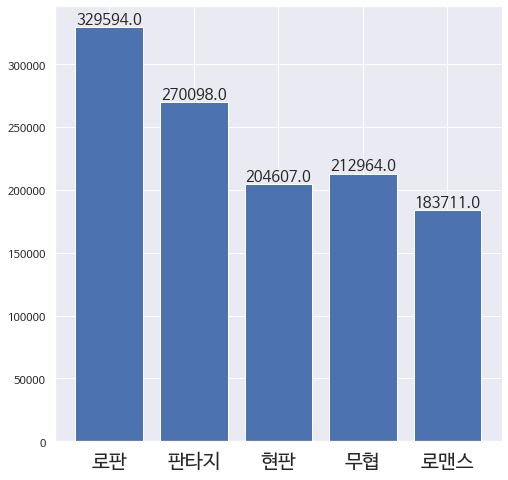

In [ ]:
fig, axes = plt.subplots(figsize=(8,8))

plt.bar(range(len(chart_df)),
        chart_df["avg_readers"])
plt.rc('font', family='NanumBarunGothic')

axes.set_xticks(range(len(chart_df)))
axes.set_xticklabels(chart_df.genre, fontsize=20)

for i, v in enumerate([0, 1, 2, 3, 4]):
    plt.text(v, chart_df["avg_readers"][i].round(), chart_df["avg_readers"][i].round(),
             fontsize = 15, 
             horizontalalignment='center',
             verticalalignment='bottom')

plt.show();

# Analysis

가설 검정의 유의 수준은 $α=0.05$

### 장르별 평균 제목 길이

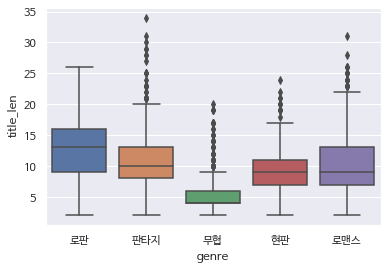

In [ ]:
# boxplot

sns.boxplot(x='genre', y='title_len', data=df);

> 가설 검정 : 장르 간의 평균 차이가 통계적으로 유의할까?

$ H_0 $ : 로판.mean = 판타지.mean = 무협.mean = 현판.mean = 로맨스.mean

$ H_1 $ : not $ H_0 $




In [ ]:
import scipy.stats as stats

fvalue, pvalue = stats.f_oneway(romance_fantasy['title_len'], fantasy['title_len'], martial['title_len'], real_fantasy['title_len'], romance['title_len'])

print(fvalue, pvalue)

254.67865180271048 1.4900098134464895e-195


- `p < 0.05`이므로 다섯 장르의 제목 평균 길이가 모두 같다고 할 수 없다. 즉, **적어도 하나는 다르다.**

> 가설 검정 : 판타지 장르 간의 평균 차이가 통계적으로 유의할까?

$ H_0 $ : 로판.mean = 판타지.mean = 현판.mean

$ H_1 $ : not $ H_0 $

In [ ]:
print(romance_fantasy['title_len'].mean(), fantasy['title_len'].mean(), real_fantasy['title_len'].mean())

12.424586776859504 10.483388704318937 9.268892794376098


In [ ]:
import scipy.stats as stats

fvalue, pvalue = stats.f_oneway(romance_fantasy['title_len'], fantasy['title_len'], real_fantasy['title_len'])

print(fvalue, pvalue)

113.95692952752097 2.8930261569662426e-48


- `p < 0.05`이므로 다섯 장르의 제목 평균 길이가 모두 같다고 할 수 없다. 즉, **적어도 하나는 다르다.**

In [ ]:
fantasy_all['title_len'].mean()

10.916818679314119

In [ ]:
martial['title_len'].mean()

5.434704830053668

In [ ]:
romance['title_len'].mean()

10.269922879177377

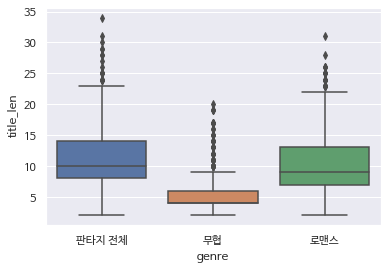

In [ ]:
fantasy_total_df = df.copy()
fantasy_total_df['genre'] = fantasy_total_df['genre'].apply(lambda x:'판타지 전체' if x=='판타지' or x=='로판' or x=='현판' else x)

# box plot

sns.boxplot(x='genre', y='title_len', data=fantasy_total_df);

> 가설 검정 : 셋의 평균 차이가 통계적으로 유의할까?

$ H_0 $ : fantasy_all.mean = martial.mean = romance.mean

$ H_1 $ : not $ H_0 $

In [ ]:
import scipy.stats as stats

fvalue, pvalue = stats.f_oneway(fantasy_all['title_len'], martial['title_len'], romance['title_len'])

print(fvalue, pvalue)

376.21281096825726 1.1600979600745285e-150


- `p < 0.05`이므로 세 장르의 제목 평균 길이가 모두 같다고 할 수 없다. 즉, **적어도 하나는 다르다.**

> 추가 검정 : 판타지와 로맨스의 평균 차이가 통계적으로 유의할까?

$ H_0 $ : fantasy_all.mean = romance.mean

$ H_1 $ : not $ H_0 $

In [ ]:
# ! pip install --upgrade scipy

In [ ]:
from scipy import stats

stats.ttest_ind(fantasy_all['title_len'], romance['title_len'], alternative='greater')

Ttest_indResult(statistic=3.553979049622954, pvalue=0.00019221937200601392)

- `p < 0.05`이므로 차이가 통계적으로 유의하다.

### 장르별 이용 등급에 따른 독자 수 차이

In [ ]:
# 판타지
fantasy_all_all = fantasy_all[fantasy_all['grade']=='전체이용가']
fantasy_all_15 = fantasy_all[fantasy_all['grade']=='15세이용가']

# 무협
martial_all = martial[martial['grade']=='전체이용가']
martial_15 = martial[martial['grade']=='15세이용가']

# 로맨스
romance_all = romance[romance['grade']=='전체이용가']
romance_15 = romance[romance['grade']=='15세이용가']

> 가설 검정 : 전체 이용가의 평균 독자 수가 15세 이용가보다 많을 것이다.

$ H_0 $ : all_readers.mean > 15_readers.mean

$ H_1 $ : not $ H_0 $



In [ ]:
# 판타지
stats.ttest_ind(fantasy_all_all['readers'], fantasy_all_15['readers'], alternative='greater')

Ttest_indResult(statistic=3.6008078970382407, pvalue=0.00016143161197956261)

In [ ]:
# 로맨스
stats.ttest_ind(romance_all['readers'], romance_15['readers'], alternative='greater')

Ttest_indResult(statistic=6.552560593829729, pvalue=5.150422831414529e-11)

In [ ]:
# 무협
stats.ttest_ind(martial_all['readers'], martial_15['readers'])

Ttest_indResult(statistic=1.4466035585359225, pvalue=0.1485704808407764)

- 판타지와 로맨스는 **전체이용가의 평균 독자 수가 많다**고 할 수 있다.

- 무협은 전체이용가와 15세 이용가의 평균 독자 수에 **차이가 없다**고 볼 수 있다. 

### 독자 수와 연속형 변수 상관 분석

In [ ]:
# 연재 일수에 비정기 연재 제외
days_df = df[df['days_count'] != 0]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


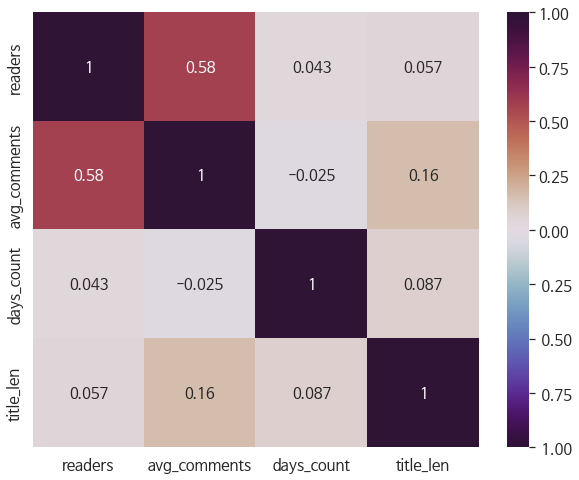

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, axes = plt.subplots(figsize=(10,8))
plt.rc('font', size=15)

ax = sns.heatmap(days_df[['readers', 'avg_comments', 'days_count', 'title_len']].corr(), cmap='twilight_shifted', vmin=-1, vmax=1, annot=True)

- 소설의 독자 수는 연재 일 수, 제목의 길이와 연관이 없다.

- 독자 수는 평균 댓글 수와 상관 관계가 있다고 할 수 있으나, 작가나 출판사가 통제할 수 있는 부분이 아니다.

- 이외에 모든 연속형 변수는 서로 연관이 없다. 따라서 회귀분석은 하지 않는다.

### A, B등급의 장르별 제목 text mining

판타지도 세부 장르를 다시 나눠서 분석

#### 폰트 설치,  KoNLPy, macab 설치

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

sys_font = fm.findSystemFonts()

[f for f in sys_font if 'Nanum' in f]

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
fm._rebuild()

NanumBarunGothic


In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

In [ ]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [ ]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

Installing automake (A dependency for mecab-ko)
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.l

In [ ]:
# test
import konlpy
from konlpy.tag import Kkma, Komoran, Hannanum, Okt
from konlpy.utils import pprint
from konlpy.tag import Mecab

mecab = Mecab()
sentence = "안녕하세요 저는 천재입니다. abc"
temp_X = mecab.nouns(sentence)
temp_X

['안녕', '저', '천재']

#### 토큰화

In [ ]:
import re
regex = r"[^a-zA-Z0-9가-힣]"
subst = ""

In [ ]:
def tokenize(text):
    """text 문자열을 의미있는 단어 단위로 list에 저장합니다.
    Args:
        text (str): 토큰화 할 문자열
    Returns:
        list: 토큰이 저장된 리스트
    """
    # 정규식 적용
    tokens = re.sub(regex, subst, text)

    # 토큰화
    tokens = mecab.nouns(tokens)
    
    return tokens

In [ ]:
df_ab = df[(df['novel_grade']=='A') | (df['novel_grade']=='B')]

In [ ]:
romance_fantasy_ab = df_ab[df_ab['genre']=='로판']
fantasy_ab = df_ab[df_ab['genre']=='판타지']
real_fantasy_ab = df_ab[df_ab['genre']=='현판']
martial_ab = df_ab[df_ab['genre']=='무협']
romance_ab = df_ab[df_ab['genre']=='로맨스']

In [ ]:
romance_fantasy_title_df = pd.DataFrame(romance_fantasy_ab['title'])
romance_fantasy_title_df['token'] = romance_fantasy_ab['title'].apply(tokenize)

fantasy_title_df = pd.DataFrame(fantasy_ab['title'])
fantasy_title_df['token'] = fantasy_ab['title'].apply(tokenize)

real_fantasy_title_df = pd.DataFrame(real_fantasy_ab['title'])
real_fantasy_title_df['token'] = real_fantasy_ab['title'].apply(tokenize)

martial_title_df = pd.DataFrame(martial_ab['title'])
martial_title_df['token'] = martial_ab['title'].apply(tokenize)

romance_title_df = pd.DataFrame(romance_ab['title'])
romance_title_df['token'] = romance_ab['title'].apply(tokenize)

#### 불필요한 단어 제거

In [ ]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

stop_words_text = "선공개 공개 단독 단독선공개"
stop_words = stop_words_text.split(' ')

In [ ]:
def remove_words(tokens):
  result = []
  for token in tokens:
    token = [word for word in token if not word in stop_words]
    result.append(token)
  return result

In [ ]:
romance_fantasy_title_df['token2'] = remove_words(romance_fantasy_title_df['token'])

fantasy_title_df['token2'] = remove_words(fantasy_title_df['token'])

real_fantasy_title_df['token2'] = remove_words(real_fantasy_title_df['token'])

martial_title_df['token2'] = remove_words(martial_title_df['token'])

romance_title_df['token2'] = remove_words(romance_title_df['token'])

#### 키워드 추출

In [ ]:
from collections import Counter
romance_fantasy_word_counts = Counter()
fantasy_word_counts = Counter()
real_fantasy_word_counts = Counter()
martial_word_counts = Counter()
romance_word_counts = Counter()

romance_fantasy_title_df['token'].apply(lambda x: romance_fantasy_word_counts.update(x))
fantasy_title_df['token'].apply(lambda x: fantasy_word_counts.update(x))
real_fantasy_title_df['token'].apply(lambda x: real_fantasy_word_counts.update(x))
martial_title_df['token'].apply(lambda x: martial_word_counts.update(x))
romance_title_df['token'].apply(lambda x: romance_word_counts.update(x))

In [ ]:
romance_fantasy_title_df

,title,token,token2
0,남주들의 집착보다 내 탈영이 빠르겠다,"[남주, 집착, 내, 탈영]","[남주, 집착, 내, 탈영]"
3,7번의 결혼이 예정되어 있습니다,"[번, 결혼, 예정]","[번, 결혼, 예정]"
9,이 3세는 악역입니다,"[세, 악역]","[세, 악역]"
34,시한부 엑스트라의 시간,"[시한부, 엑스트라, 시간]","[시한부, 엑스트라, 시간]"
36,이번 생은 가주가 되겠습니다,"[이번, 가주]","[이번, 가주]"
...,...,...,...
3880,공녀의 두 번째 시간,"[공녀, 번, 시간]","[공녀, 번, 시간]"
3900,철벽치는 성녀님,"[철벽, 성녀]","[철벽, 성녀]"
3927,순백색 황후,"[순백색, 황후]","[순백색, 황후]"
3950,약사 클라라,"[약사, 클라라]","[약사, 클라라]"


In [ ]:
def word_count(docs):
    """ 토큰화된 문서들을 입력받아 토큰을 카운트 하고 관련된 속성을 가진 데이터프레임을 리턴
    Args:
        docs (series or list): 토큰화된 문서가 들어있는 list
    Returns:
        list: Dataframe
    """
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [ ]:
# 로맨스 판타지
romance_fantasy_wc = word_count(romance_fantasy_title_df['token2'])
romance_fantasy_wc_20 = romance_fantasy_wc[romance_fantasy_wc['rank'] <= 20]

In [ ]:
# 판타지
fantasy_wc = word_count(fantasy_title_df['token2'])
fantasy_wc_20 = fantasy_wc[fantasy_wc['rank'] <= 20]

In [ ]:
# 현실 판타지
real_fantasy_wc = word_count(real_fantasy_title_df['token2'])
real_fantasy_wc_20 = real_fantasy_wc[real_fantasy_wc['rank'] <= 20]

In [ ]:
# 무협
martial_wc = word_count(martial_title_df['token2'])
martial_wc_20 = martial_wc[martial_wc['rank'] <= 20]

In [ ]:
# 로맨스
romance_wc = word_count(romance_title_df['token2'])
romance_wc_20 = romance_wc[romance_wc['rank'] <= 20]

In [ ]:
!pip install squarify

In [ ]:
import squarify

plt.rc('font', family='NanumBarunGothic')

In [ ]:
def keyword_squarify(wc_20, cmap):
  fig, axes = plt.subplots(figsize=(10, 8))
  # cmap = matplotlib.cm.summer_r
  mini=min(wc_20['percent'])
  maxi=max(wc_20['percent'])
  norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
  colors = [cmap(norm(value)) for value in wc_20['percent']]

  squarify.plot(sizes=wc_20['percent'], label=wc_20['word'], alpha=0.6, text_kwargs={'fontsize':18}, color=colors)
  plt.axis('off')
  plt.show()

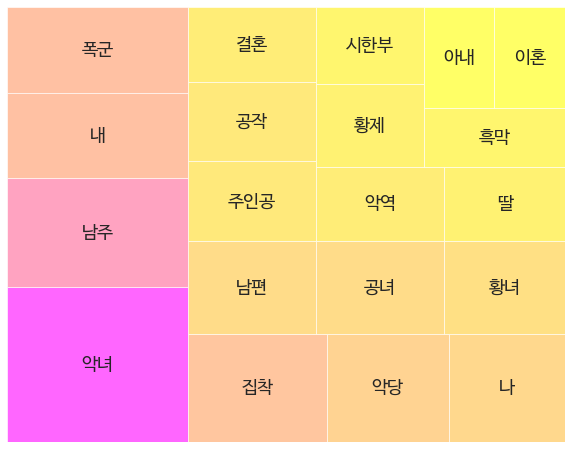

In [ ]:
keyword_squarify(romance_fantasy_wc_20, matplotlib.cm.spring_r)

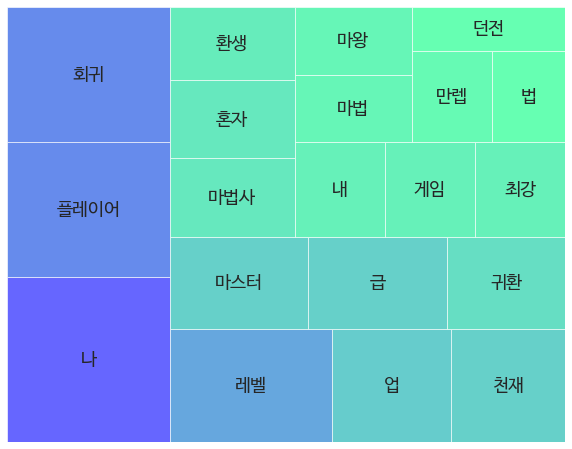

In [ ]:
keyword_squarify(fantasy_wc_20, matplotlib.cm.winter_r)

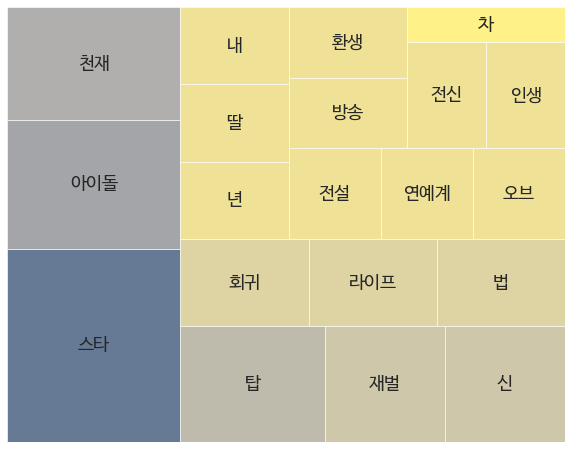

In [ ]:
keyword_squarify(real_fantasy_wc_20, matplotlib.cm.cividis_r)

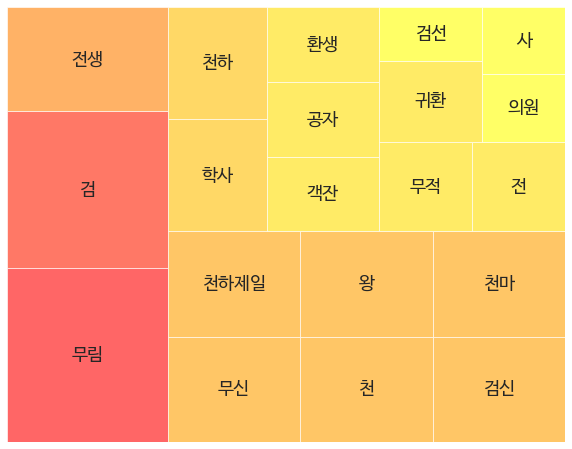

In [ ]:
keyword_squarify(martial_wc_20, matplotlib.cm.autumn_r)

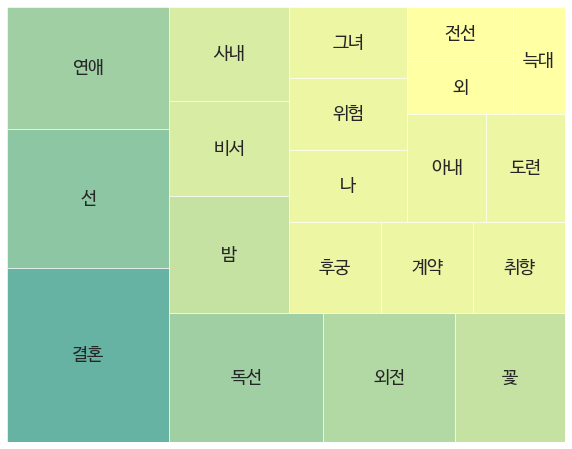

In [ ]:
keyword_squarify(romance_wc_20, matplotlib.cm.summer_r)